In [5]:
#环境配置
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import random
from IPython import display
import pandas as pd
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
import math

In [6]:
# 设置随机种子
def set_random_seeds(seed_value=2020, device='cpu'):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    random.seed(seed_value)
    if device != 'cpu':
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
set_random_seeds(2020, device)

Using device: cuda


In [7]:
#权重初始化
def init_weights_(m):
    """初始化权重"""
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.ones_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.BatchNorm1d):
        nn.init.ones_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

In [8]:
#导入数据CIFAR-10
def get_cifar_loader(root='./data/', batch_size=128, train=True, shuffle=True, num_workers=2):
    """获取CIFAR-10数据加载器"""
    normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])

    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])

    transform = transform_train if train else transform_test

    dataset = torchvision.datasets.CIFAR10(
        root=root,
        train=train,
        download=True,
        transform=transform
    )

    loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers
    )

    return loader

######尝试实现要求3中尝试模型设计中的others部分，以及要求4中优化策略的正则化技术
#实现Cutout数据增强
class Cutout:
    def __init__(self, n_holes=1, length=16):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        h, w = img.size(1), img.size(2)#图像的长宽
        mask = np.ones((h, w), np.float32)

        for _ in range(self.n_holes):
            y = np.random.randint(h)#随机x和y坐标
            x = np.random.randint(w)

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1:y2, x1:x2] = 0.#将矩形区域设置0

        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img = img * mask

        return img

####这部分尝试要求5中Try different optimizers using torch.optim
#AutoAugment策略
class CIFAR10Policy:
    """ CIFAR-10 AutoAugment"""
    def __init__(self):
        self.policies = [
            transforms.RandomChoice([
                transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
                transforms.ColorJitter(brightness=0.2, contrast=0.2)
            ]),
            transforms.RandomChoice([
                transforms.RandomRotation(15),
                transforms.RandomAffine(degrees=0, shear=10)
            ])
        ]

    def __call__(self, img):
        for policy in self.policies:
            if np.random.random() < 0.5:
                img = policy(img)#50%概率应用策略
        return img


In [9]:
######测试数据增强
#高级数据增强的数据加载器
def get_cifar_loader_advanced(root='./data/', batch_size=128, train=True, shuffle=True, num_workers=2):
    """获取CIFAR-10数据加载器（高级数据增强）"""
    #使用ImageNet的标准化参数
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                   std=[0.229, 0.224, 0.225])

    transform_train_advanced = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        CIFAR10Policy(),  # AutoAugment策略
        transforms.ToTensor(),
        normalize,
        Cutout(n_holes=1, length=16)  # Cutout
    ])

    # 添加更多数据增强选项
    transform_train_strong = transforms.Compose([
        transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
        transforms.RandomHorizontalFlip(),
        transforms.RandomChoice([
            transforms.RandomRotation(15),
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
            transforms.RandomAffine(degrees=0, shear=10)
        ]),
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
        transforms.RandomGrayscale(p=0.2),
        transforms.ToTensor(),
        normalize,
        transforms.RandomErasing(p=0.5, scale=(0.02, 0.33))  # 替代Cutout
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])

    #根据训练强度选择不同的数据增强
    if train:
        transform = transform_train_advanced  #可以切换到transform_train_strong
    else:
        transform = transform_test

    dataset = torchvision.datasets.CIFAR10(
        root=root,
        train=train,
        download=True,
        transform=transform
    )

    loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers,
        pin_memory=True  #要求4性能优化：加速数据传输、多进程加载、批量处理
    )

    return loader

####advance加不加root测试
# 加载数据
train_loader = get_cifar_loader(train=True, batch_size=128)
val_loader = get_cifar_loader(train=False, batch_size=128)
train_loader_advanced = get_cifar_loader_advanced(root='./data/', train=True, batch_size=128)

100%|██████████| 170M/170M [00:19<00:00, 8.61MB/s] 


In [10]:
###实现2.2 VGG-Awith&without BN
#基础VGG_A模型_没有BN
class VGG_A(nn.Module):
    def __init__(self, inp_ch=3, num_classes=10, init_weights=True):
        super().__init__()
        #五个stage特征提取
        self.features = nn.Sequential(
            # stage 1
            nn.Conv2d(inp_ch, 64, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # stage 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # stage 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # stage 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # stage 5
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        #分类器，三个全连接层
        self.classifier = nn.Sequential(
            nn.Linear(512 * 1 * 1, 512),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

        if init_weights:
            self._init_weights()

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _init_weights(self):
        for m in self.modules():
            init_weights_(m)

# 带批归一化的VGG_A模型_添加BN层
class VGG_A_BatchNorm(nn.Module):
    def __init__(self, inp_ch=3, num_classes=10, init_weights=True):
        super().__init__()

        self.features = nn.Sequential(
            # stage 1
            nn.Conv2d(inp_ch, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # stage 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # stage 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # stage 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # stage 5
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(512 * 1 * 1, 512),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

        if init_weights:
            self._init_weights()

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _init_weights(self):
        for m in self.modules():
            init_weights_(m)

In [11]:
#改进使用残差连接_尝试实现要求3 Residual Connection​
class VGG_A_Residual(nn.Module):
    def __init__(self, inp_ch=3, num_classes=10):
        super().__init__()

        # 定义残差块
        class ResidualBlock(nn.Module):
            def __init__(self, in_channels, out_channels):
                super().__init__()
                self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
                self.bn1 = nn.BatchNorm2d(out_channels)
                self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
                self.bn2 = nn.BatchNorm2d(out_channels)
                self.relu = nn.ReLU(True)

                # 如果输入输出通道数不同，使用1x1卷积匹配
                self.shortcut = nn.Sequential()
                if in_channels != out_channels:
                    self.shortcut = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, 1),
                        nn.BatchNorm2d(out_channels)
                    )

            def forward(self, x):
                out = self.relu(self.bn1(self.conv1(x)))
                out = self.bn2(self.conv2(out))
                out += self.shortcut(x)
                out = self.relu(out)
                return out

        self.features = nn.Sequential(
            nn.Conv2d(inp_ch, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            ResidualBlock(64, 64),
            nn.MaxPool2d(2, 2),

            ResidualBlock(64, 128),
            nn.MaxPool2d(2, 2),

            ResidualBlock(128, 256),
            ResidualBlock(256, 256),
            nn.MaxPool2d(2, 2),

            ResidualBlock(256, 512),
            ResidualBlock(512, 512),
            nn.MaxPool2d(2, 2),

            ResidualBlock(512, 512),
            ResidualBlock(512, 512),
            nn.AdaptiveAvgPool2d((1, 1))
        )

        self.classifier = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

        self._init_weights()

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _init_weights(self):
        for m in self.modules():
            init_weights_(m)

In [12]:
#改进_使用残差连接+更多Dropout_尝试实现要求3中的dropout，dropout正则
class VGG_A_Residual_Dropout(nn.Module):
    def __init__(self, inp_ch=3, num_classes=10, dropout_rate=0.3):
        super().__init__()

        # Dropout
        class ResidualBlockWithDropout(nn.Module):
            def __init__(self, in_channels, out_channels, dropout_rate=0.3):
                super().__init__()
                self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
                self.bn1 = nn.BatchNorm2d(out_channels)
                self.dropout1 = nn.Dropout2d(dropout_rate)
                self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
                self.bn2 = nn.BatchNorm2d(out_channels)
                self.dropout2 = nn.Dropout2d(dropout_rate)
                self.relu = nn.ReLU(True)

                self.shortcut = nn.Sequential()
                if in_channels != out_channels:
                    self.shortcut = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, 1),
                        nn.BatchNorm2d(out_channels)
                    )

            def forward(self, x):
                out = self.relu(self.bn1(self.conv1(x)))
                out = self.dropout1(out)
                out = self.bn2(self.conv2(out))
                out = self.dropout2(out)
                out += self.shortcut(x)
                out = self.relu(out)
                return out

        self.features = nn.Sequential(
            nn.Conv2d(inp_ch, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            ResidualBlockWithDropout(64, 64, dropout_rate),
            nn.MaxPool2d(2, 2),

            ResidualBlockWithDropout(64, 128, dropout_rate),
            nn.MaxPool2d(2, 2),

            ResidualBlockWithDropout(128, 256, dropout_rate),
            ResidualBlockWithDropout(256, 256, dropout_rate),
            nn.MaxPool2d(2, 2),

            ResidualBlockWithDropout(256, 512, dropout_rate),
            ResidualBlockWithDropout(512, 512, dropout_rate),
            nn.MaxPool2d(2, 2),

            ResidualBlockWithDropout(512, 512, dropout_rate),
            ResidualBlockWithDropout(512, 512, dropout_rate),
            nn.AdaptiveAvgPool2d((1, 1))
        )

        self.classifier = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

        self._init_weights()

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _init_weights(self):
        for m in self.modules():
            init_weights_(m)

#VGG_使用不同激活函数，要求4c
class VGG_A_GELU(nn.Module):
    def __init__(self, inp_ch=3, num_classes=10):
        super().__init__()

        self.features = nn.Sequential(
            # stage 1
            nn.Conv2d(inp_ch, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.GELU(),  # 使用GELU激活函数
            nn.MaxPool2d(kernel_size=2, stride=2),

            # stage 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.GELU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # stage 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.GELU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.GELU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # stage 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.GELU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.GELU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # stage 5
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.GELU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.GELU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(512 * 1 * 1, 512),
            nn.GELU(),
            nn.Dropout(0.5),
            nn.Linear(512, 512),
            nn.GELU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

        self._init_weights()

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _init_weights(self):
        for m in self.modules():
            init_weights_(m)

In [13]:
# 计算模型参数数量
def get_number_of_parameters(model):
    return sum(p.numel() for p in model.parameters())

In [14]:
# 打印模型参数数量
models = {
    'VGG_A': VGG_A(),
    'VGG_A_BatchNorm': VGG_A_BatchNorm(),
    'VGG_A_Residual': VGG_A_Residual(),
    'VGG_A_Residual_Dropout': VGG_A_Residual_Dropout(),
    'VGG_A_GELU': VGG_A_GELU()
}

for name, model in models.items():
    print(f"{name} 参数数量: {get_number_of_parameters(model):,}")

VGG_A 参数数量: 9,750,922
VGG_A_BatchNorm 参数数量: 9,756,426
VGG_A_Residual 参数数量: 20,514,954
VGG_A_Residual_Dropout 参数数量: 20,514,954
VGG_A_GELU 参数数量: 9,756,426


In [15]:
def get_accuracy(model, data_loader, device):
    """计算模型准确率"""
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    return 100 * correct / total

def train_epoch(model, train_loader, criterion, optimizer, device):
    """训练一个epoch"""
    model.train()
    running_loss = 0.0

    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    return running_loss / len(train_loader)

def train(model, optimizer, criterion, train_loader, val_loader,
          scheduler=None, epochs_n=20, model_name='model'):
    """训练"""
    model.to(device)

    train_losses = []
    train_accuracies = []
    val_accuracies = []
    best_val_acc = 0

    #创建进度条
    pbar = tqdm(range(epochs_n), desc=f'Training {model_name}')

    for epoch in pbar:
        #训练
        train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)

        #计算准确率
        train_acc = get_accuracy(model, train_loader, device)
        val_acc = get_accuracy(model, val_loader, device)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        #更新学习率
        if scheduler is not None:
          if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(val_acc)
          else:
            scheduler.step()


        #更新进度条
        pbar.set_postfix({
            'Loss': f'{train_loss:.4f}',
            'Train Acc': f'{train_acc:.2f}%',
            'Val Acc': f'{val_acc:.2f}%'
        })

        # 保存最佳模型
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), f'{model_name}_best.pth')

    return train_losses, train_accuracies, val_accuracies




In [16]:
def find_learning_rate(model, train_loader, init_lr=1e-8, end_lr=1, num_iter=100):
    """学习率查找器 - 找到最优学习率"""
    model.to(device)
    optimizer = optim.SGD(model.parameters(), lr=init_lr)
    criterion = nn.CrossEntropyLoss()

    lrs = []
    losses = []

    # 指数增长学习率
    lr_mult = (end_lr / init_lr) ** (1 / num_iter)

    model.train()
    avg_loss = 0.
    best_loss = 0.
    batch_num = 0

    for inputs, labels in train_loader:
        batch_num += 1
        if batch_num > num_iter:
            break

        inputs, labels = inputs.to(device), labels.to(device)

        # 前向传播
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # 计算平滑损失
        avg_loss = 0.95 * avg_loss + 0.05 * loss.item()
        smooth_loss = avg_loss / (1 - 0.95**batch_num)

        # 记录
        lrs.append(optimizer.param_groups[0]['lr'])
        losses.append(smooth_loss)

        # 检查是否发散
        if batch_num > 1 and smooth_loss > 4 * best_loss:
            break

        if smooth_loss < best_loss or batch_num == 1:
            best_loss = smooth_loss

        # 反向传播
        loss.backward()
        optimizer.step()

        # 更新学习率
        optimizer.param_groups[0]['lr'] *= lr_mult

    return lrs, losses

def plot_lr_finder(lrs, losses):
    """绘制学习率查找结果"""
    plt.figure(figsize=(10, 6))
    plt.plot(lrs, losses)
    plt.xscale('log')
    plt.xlabel('Learning Rate')
    plt.ylabel('Loss')
    plt.title('Learning Rate Finder')
    plt.grid(True)
    plt.show()

#####

In [17]:
# 可视化训练结果
def plot_training_curves(results_dict):
    """绘制训练曲线"""
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    # 损失曲线
    for name, results in results_dict.items():
        axes[0].plot(results['train_losses'], label=name)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training Loss')
    axes[0].legend()
    axes[0].grid(True)

    # 训练准确率
    for name, results in results_dict.items():
        axes[1].plot(results['train_accuracies'], label=name)
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].set_title('Training Accuracy')
    axes[1].legend()
    axes[1].grid(True)

    # 验证准确率
    for name, results in results_dict.items():
        axes[2].plot(results['val_accuracies'], label=name)
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Accuracy (%)')
    axes[2].set_title('Validation Accuracy')
    axes[2].legend()
    axes[2].grid(True)

    plt.tight_layout()
    plt.show()



数据增强效果可视化


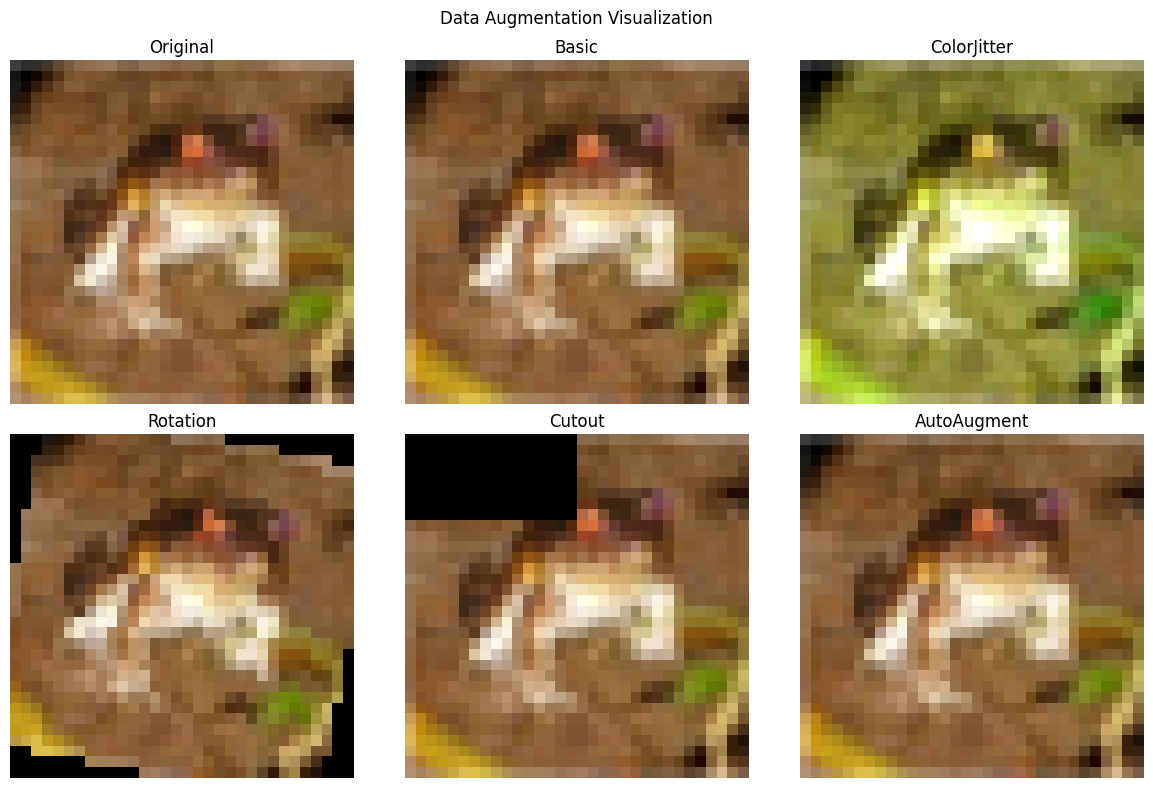

In [18]:
# 可视化数据增强效果
def visualize_augmentations():
    """可视化不同的数据增强效果"""
    # 获取一张原始图像
    dataset = torchvision.datasets.CIFAR10(root='./data/', train=True,
                                         transform=transforms.ToTensor())
    original_img = dataset[0][0]

    # 定义不同的数据增强
    augmentations = {
        'Original': transforms.Compose([]),
        'Basic': transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip()
        ]),
        'ColorJitter': transforms.ColorJitter(brightness=0.4, contrast=0.4,
                                             saturation=0.4, hue=0.1),
        'Rotation': transforms.RandomRotation(15),
        'Cutout': Cutout(n_holes=1, length=16),
        'AutoAugment': CIFAR10Policy()
    }

    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    axes = axes.ravel()

    for idx, (name, aug) in enumerate(augmentations.items()):
        if name == 'Original':
            img = original_img
        elif name == 'Cutout':
            img = aug(original_img.clone())
        else:
            # 转换为PIL图像应用增强
            img_pil = transforms.ToPILImage()(original_img)
            img_pil = aug(img_pil) if name != 'Basic' else img_pil
            img = transforms.ToTensor()(img_pil)

        axes[idx].imshow(img.permute(1, 2, 0))
        axes[idx].set_title(name)
        axes[idx].axis('off')

    plt.suptitle('Data Augmentation Visualization')
    plt.tight_layout()
    plt.show()

# 调用可视化函数
print("\n数据增强效果可视化")
visualize_augmentations()

可视化第一层卷积滤波器


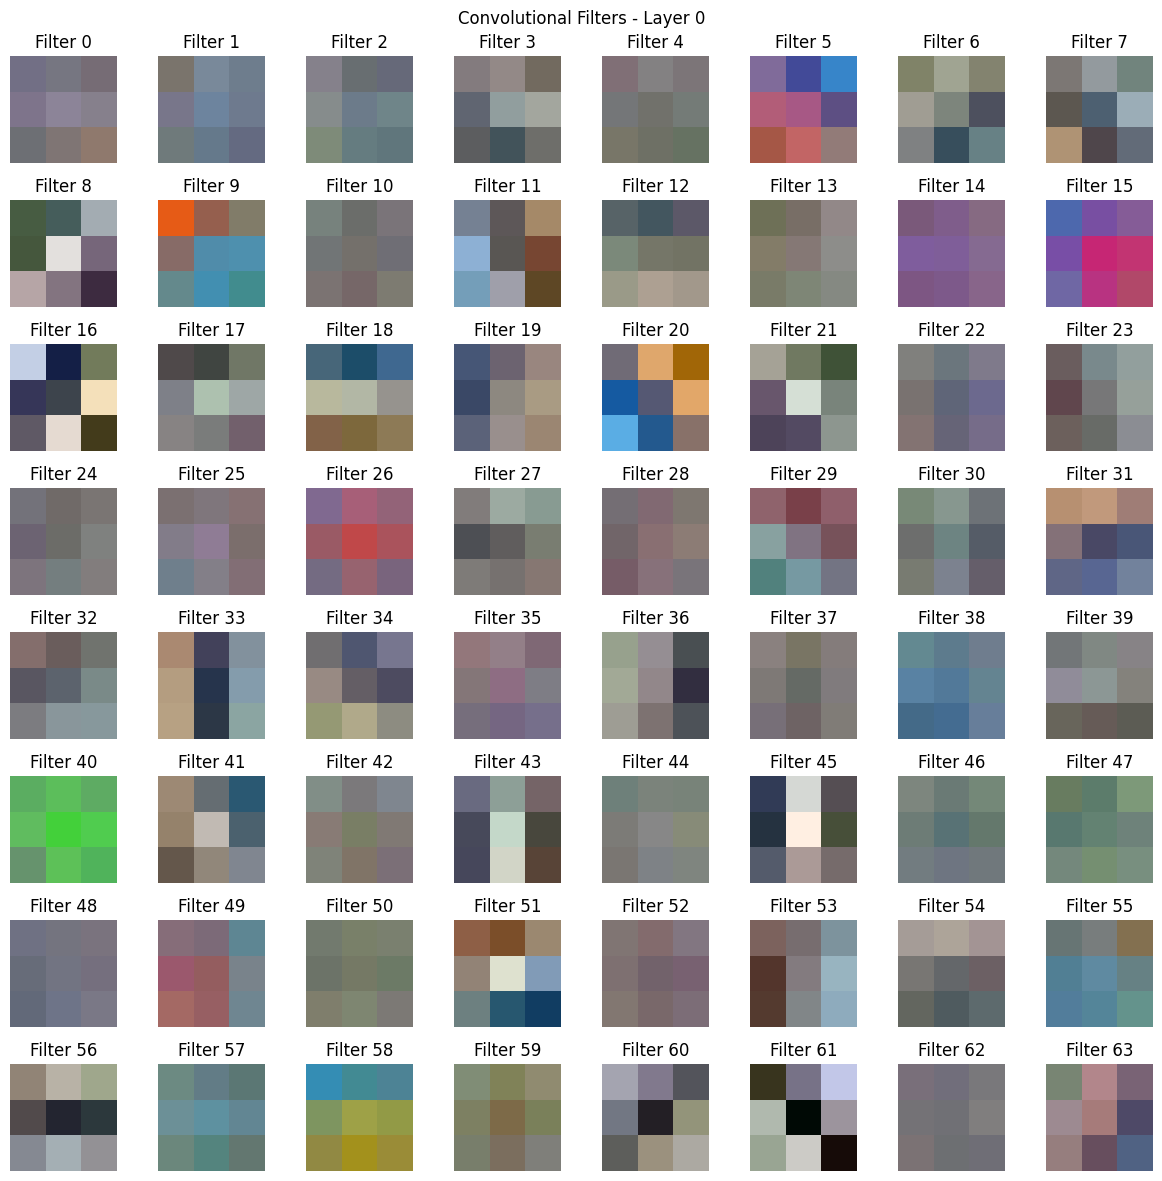

In [83]:
## 可视化网络特征
def visualize_filters(model, layer_idx=0):
    """可视化卷积层的滤波器"""
    # 获取第一个卷积层的权重
    conv_layers = []
    for module in model.modules():
        if isinstance(module, nn.Conv2d):
            conv_layers.append(module)

    if layer_idx >= len(conv_layers):
        print(f"Layer index {layer_idx} out of range. Total conv layers: {len(conv_layers)}")
        return

    weights = conv_layers[layer_idx].weight.data.cpu()

    # 归一化权重到[0, 1]
    weights = weights - weights.min()
    weights = weights / weights.max()

    # 绘制前64个滤波器（如果有的话）
    n_filters = min(64, weights.shape[0])
    n_cols = 8
    n_rows = n_filters // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 12))
    axes = axes.ravel()

    for i in range(n_filters):
        # 对于RGB图像，取三个通道的平均
        if weights.shape[1] == 3:
            filter_img = weights[i].permute(1, 2, 0)
        else:
            filter_img = weights[i, 0]

        axes[i].imshow(filter_img, cmap='gray' if weights.shape[1] != 3 else None)
        axes[i].axis('off')
        axes[i].set_title(f'Filter {i}')

    plt.suptitle(f'Convolutional Filters - Layer {layer_idx}')
    plt.tight_layout()
    plt.show()

# 可视化第一层滤波器
print("可视化第一层卷积滤波器")
visualize_filters(model_vgg_bn, layer_idx=0)



可视化特征图


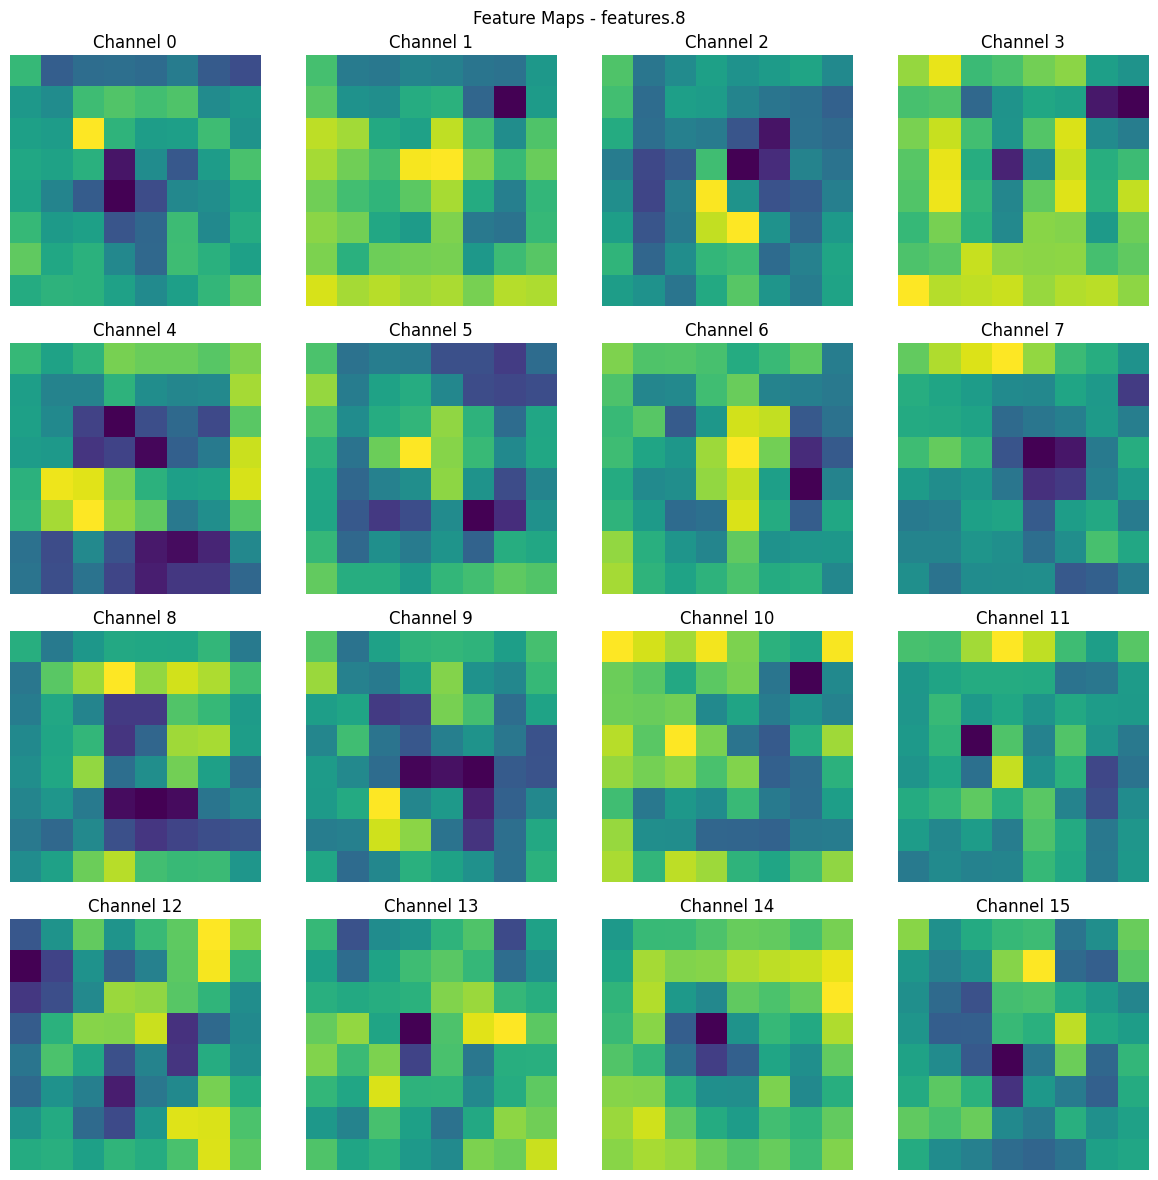


梯度流分析


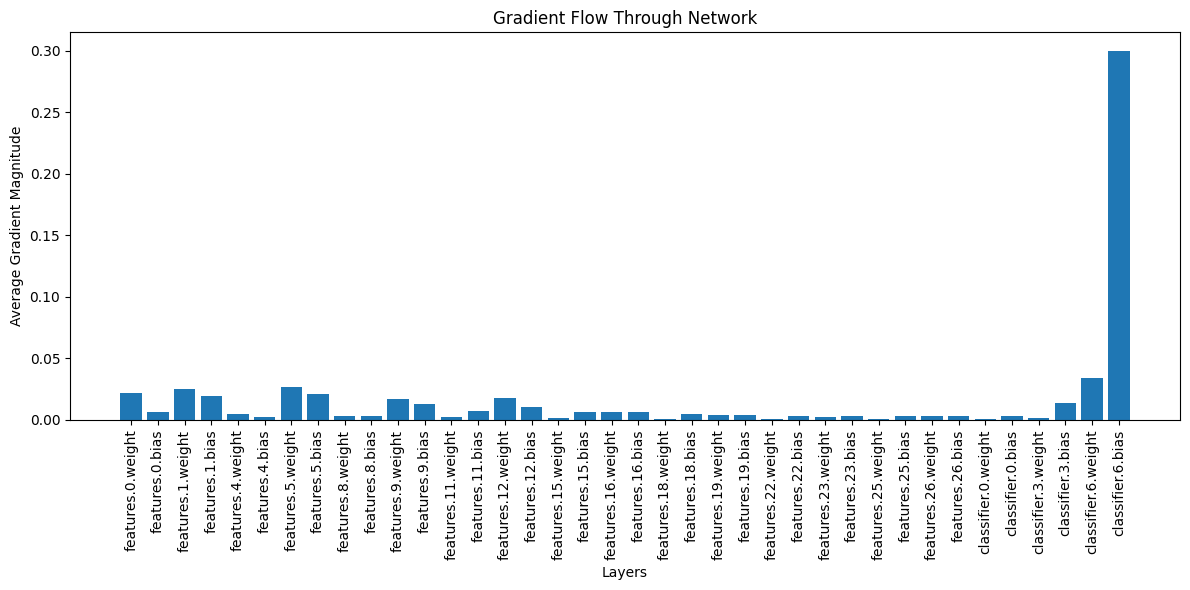


特征空间可视化


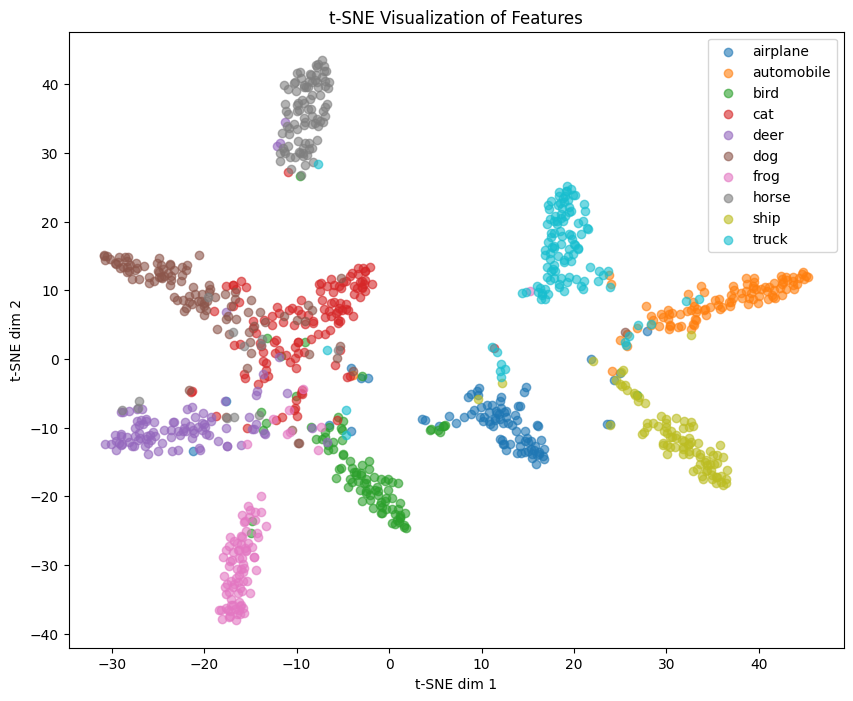

<Figure size 640x480 with 0 Axes>

In [82]:

# 可视化特征图
def visualize_feature_maps(model, layer_idx, input_batch):
    """可视化中间层特征图"""
    activation = {}

    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook

    # 注册钩子
    conv_layers = []
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            conv_layers.append((name, module))

    if layer_idx < len(conv_layers):
        name, layer = conv_layers[layer_idx]
        layer.register_forward_hook(get_activation(name))

    # 前向传播
    model.eval()
    with torch.no_grad():
        _ = model(input_batch)

    # 获取激活
    if name in activation:
        act = activation[name][0].cpu()  # 取第一个样本

        # 可视化前16个通道
        fig, axes = plt.subplots(4, 4, figsize=(12, 12))
        axes = axes.ravel()

        for i in range(min(16, act.shape[0])):
            axes[i].imshow(act[i], cmap='viridis')
            axes[i].axis('off')
            axes[i].set_title(f'Channel {i}')

        plt.suptitle(f'Feature Maps - {name}')
        plt.tight_layout()
        plt.show()

# 获取一个批次的数据用于可视化
dataiter = iter(val_loader)
images, labels = next(dataiter)
images = images.to(device)

# 可视化不同层的特征图
print("\n可视化特征图")
visualize_feature_maps(model_vgg_bn, layer_idx=2, input_batch=images)

# 梯度流可视化
print("\n梯度流分析")
sample_input = torch.randn(1, 3, 32, 32).to(device)
gradients, layer_names = visualize_gradient_flow(model_vgg_bn, sample_input)


####
# t-SNE特征可视化
from sklearn.manifold import TSNE

def visualize_features_tsne(model, data_loader, device):
    """使用t-SNE可视化最后一层特征"""
    model.eval()
    features = []
    labels_list = []

    with torch.no_grad():
        for data, labels in data_loader:
            data = data.to(device)
            # 获取倒数第二层的特征
            x = model.features(data)
            x = x.view(x.size(0), -1)
            features.append(x.cpu().numpy())
            labels_list.append(labels.numpy())

            if len(features) * data.size(0) >= 1000:  # 只取1000个样本
                break

    features = np.concatenate(features)
    labels_array = np.concatenate(labels_list)

    # t-SNE降维
    tsne = TSNE(n_components=2, random_state=42)
    features_2d = tsne.fit_transform(features)

    # 可视化
    plt.figure(figsize=(10, 8))
    classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
    colors = plt.cm.tab10(np.arange(10))

    for i in range(10):
        mask = labels_array == i
        plt.scatter(features_2d[mask, 0], features_2d[mask, 1],
                   c=[colors[i]], label=classes[i], alpha=0.6)

    plt.legend()
    plt.title('t-SNE Visualization of Features')
    plt.xlabel('t-SNE dim 1')
    plt.ylabel('t-SNE dim 2')
    plt.show()

print("\n特征空间可视化")
visualize_features_tsne(model_vgg_bn, val_loader, device)

plt.tight_layout()
plt.show()

In [19]:
#2.3.1中的损失
def train_for_loss_landscape(model, optimizer, criterion, train_loader,
                           val_loader, epochs_n=20, record_every=10):
    """训练并记录损失地形数据"""
    model.to(device)
    losses_per_step = []
    grads_per_step = []

    for epoch in tqdm(range(epochs_n), desc='Training for loss landscape'):
        model.train()
        epoch_losses = []
        epoch_grads = []

        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()

            # 记录损失和梯度
            if i % record_every == 0:
                epoch_losses.append(loss.item())
                # 记录最后一层的梯度范数
                grad_norm = torch.norm(model.classifier[-1].weight.grad).item()
                epoch_grads.append(grad_norm)

            optimizer.step()

        losses_per_step.extend(epoch_losses)
        grads_per_step.extend(epoch_grads)

    return losses_per_step, grads_per_step

def plot_loss_landscape_comparison(results_standard, results_bn):
    """比较有无BatchNorm的损失地形"""
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # 损失地形
    for lr, losses in results_standard.items():
        axes[0].plot(losses, alpha=0.7, label=f'LR={lr}')
    axes[0].set_xlabel('Steps')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Standard VGG Loss Landscape')
    axes[0].legend()
    axes[0].grid(True)

    for lr, losses in results_bn.items():
        axes[1].plot(losses, alpha=0.7, label=f'LR={lr}')
    axes[1].set_xlabel('Steps')
    axes[1].set_ylabel('Loss')
    axes[1].set_title('VGG with BatchNorm Loss Landscape')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

In [20]:
#2.3BN优化
def compute_gradient_predictiveness(model, train_loader, criterion, steps=50, alpha=0.1):
    """计算梯度预测性 -测量梯度的稳定性"""
    model.to(device)
    model.eval()

    gradient_errors = []

    for i, (inputs, labels) in enumerate(train_loader):
        if i >= steps:
            break

        inputs, labels = inputs.to(device), labels.to(device)

        # 计算原始点的梯度
        model.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        # 保存原始梯度
        original_grads = []
        for param in model.parameters():
            if param.grad is not None:
                original_grads.append(param.grad.clone())

        # 在梯度方向上移动一小步
        with torch.no_grad():
            idx = 0
            for param in model.parameters():
                if param.grad is not None:
                    param.data += alpha * original_grads[idx]
                    idx += 1

        # 计算新位置的梯度
        model.zero_grad()
        outputs = model(inputs)
        loss_new = criterion(outputs, labels)
        loss_new.backward()

        # 计算梯度差异
        grad_diff = 0
        idx = 0
        for param in model.parameters():
            if param.grad is not None:
                grad_diff += torch.norm(param.grad - original_grads[idx]).item()
                idx += 1

        gradient_errors.append(grad_diff)

        # 恢复原始参数
        with torch.no_grad():
            idx = 0
            for param in model.parameters():
                if param.grad is not None:
                    param.data -= alpha * original_grads[idx]
                    idx += 1

    return gradient_errors

####
def compute_gradient_smoothness(model, train_loader, criterion, steps=50):
    """计算梯度平滑度 -测量梯度的利普希茨连续性"""
    model.to(device)
    model.eval()

    smoothness_values = []

    for i, (inputs, labels) in enumerate(train_loader):
        if i >= steps:
            break

        inputs, labels = inputs.to(device), labels.to(device)
        batch_size = inputs.size(0)

        # 生成随机扰动
        noise = torch.randn_like(inputs) * 0.01
        inputs_perturbed = inputs + noise

        # 计算原始梯度
        model.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        grads_original = []
        for param in model.parameters():
            if param.grad is not None:
                grads_original.append(param.grad.clone().flatten())
        grads_original = torch.cat(grads_original)

        # 计算扰动后的梯度
        model.zero_grad()
        outputs_perturbed = model(inputs_perturbed)
        loss_perturbed = criterion(outputs_perturbed, labels)
        loss_perturbed.backward()

        grads_perturbed = []
        for param in model.parameters():
            if param.grad is not None:
                grads_perturbed.append(param.grad.clone().flatten())
        grads_perturbed = torch.cat(grads_perturbed)

        # 计算梯度差异与输入差异的比值（Lipschitz常数的估计）
        grad_diff = torch.norm(grads_original - grads_perturbed)
        input_diff = torch.norm(noise.view(batch_size, -1), dim=1).mean()

        smoothness = (grad_diff / input_diff).item()
        smoothness_values.append(smoothness)

    return smoothness_values

####
def compute_gradient_distance_variation(model, train_loader, criterion, distances=[0.01, 0.05, 0.1]):
    """计算不同距离下的梯度变化"""
    model.eval()
    results = {}

    for distance in distances:
        grad_diffs = []
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # 计算原始梯度
            model.zero_grad()
            loss = criterion(model(inputs), labels)
            loss.backward()

            original_grads = [p.grad.clone() for p in model.parameters() if p.grad is not None]

            # 在梯度方向移动指定距离
            with torch.no_grad():
                for p, g in zip(model.parameters(), original_grads):
                    p.data += distance * g

            # 计算新位置的梯度
            model.zero_grad()
            loss_new = criterion(model(inputs), labels)
            loss_new.backward()

            # 计算梯度差异
            grad_diff = sum(torch.norm(p.grad - g).item()
                          for p, g in zip(model.parameters(), original_grads))
            grad_diffs.append(grad_diff / distance)

            # 恢复参数
            with torch.no_grad():
                for p, g in zip(model.parameters(), original_grads):
                    p.data -= distance * g

            break  # 只用第一个batch演示

        results[distance] = np.mean(grad_diffs)

    return results


def visualize_gradient_flow(model, input_tensor):
    """可视化梯度流"""
    model.eval()
    input_tensor.requires_grad_()

    output = model(input_tensor)
    loss = output.mean()
    loss.backward()

    # 收集每层的梯度
    gradients = []
    layer_names = []

    for name, param in model.named_parameters():
        if param.grad is not None:
            gradients.append(param.grad.abs().mean().item())
            layer_names.append(name)

    # 绘制梯度流
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(gradients)), gradients)
    plt.xticks(range(len(gradients)), layer_names, rotation=90)
    plt.xlabel('Layers')
    plt.ylabel('Average Gradient Magnitude')
    plt.title('Gradient Flow Through Network')
    plt.tight_layout()
    plt.show()

    return gradients, layer_names

梯度距离最大差异分析


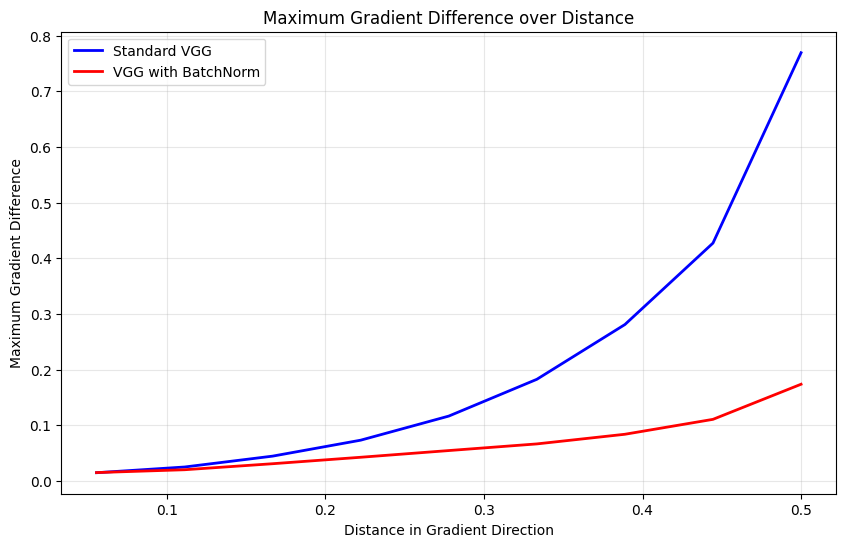


标准VGG平均最大梯度差异: 0.2150
BatchNorm VGG平均最大梯度差异: 0.0666
改善比例: 69.03%


In [23]:
#实现2.3梯度距离最大差异测量
def compute_max_gradient_difference(model, train_loader, criterion, num_steps=10, max_distance=0.5):
    """
    测量梯度在不同距离上的最大差异
    这个函数实现了"Maximum difference in gradient over the distance"的要求
    """
    model.to(device)
    model.eval()

    distances = np.linspace(0, max_distance, num_steps)
    max_grad_diffs = []

    # 获取一个batch的数据
    data_iter = iter(train_loader)
    inputs, labels = next(data_iter)
    inputs, labels = inputs.to(device), labels.to(device)

    # 计算原始点的梯度
    model.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()

    # 保存原始梯度和参数
    original_grads = []
    original_params = []
    for param in model.parameters():
        if param.grad is not None:
            original_grads.append(param.grad.clone())
            original_params.append(param.data.clone())

    # 对每个距离计算梯度差异
    for dist in distances[1:]:  # 跳过0
        # 在梯度方向上移动
        with torch.no_grad():
            for i, param in enumerate(model.parameters()):
                if param.grad is not None:
                    # 归一化梯度方向
                    grad_norm = original_grads[i].norm()
                    if grad_norm > 0:
                        param.data = original_params[i] + dist * original_grads[i] / grad_norm

        # 计算新位置的梯度
        model.zero_grad()
        outputs = model(inputs)
        loss_new = criterion(outputs, labels)
        loss_new.backward()

        # 计算最大梯度差异
        max_diff = 0
        for i, param in enumerate(model.parameters()):
            if param.grad is not None:
                diff = torch.max(torch.abs(param.grad - original_grads[i])).item()
                max_diff = max(max_diff, diff)

        max_grad_diffs.append(max_diff)

        # 恢复原始参数
        with torch.no_grad():
            for i, param in enumerate(model.parameters()):
                if param.grad is not None:
                    param.data = original_params[i].clone()

    return distances[1:], max_grad_diffs

# 执行梯度距离分析
print("梯度距离最大差异分析")

# 对比有无BN的梯度距离差异
criterion = nn.CrossEntropyLoss()  # 定义损失函数

# 初始化模型
model_standard = VGG_A()
model_bn = VGG_A_BatchNorm()

# 初始化模型权重
model_standard.apply(init_weights_)
model_bn.apply(init_weights_)

distances_std, max_diffs_std = compute_max_gradient_difference(model_standard, train_loader, criterion)
distances_bn, max_diffs_bn = compute_max_gradient_difference(model_bn, train_loader, criterion)

# 可视化结果
plt.figure(figsize=(10, 6))
plt.plot(distances_std, max_diffs_std, 'b-', label='Standard VGG', linewidth=2)
plt.plot(distances_bn, max_diffs_bn, 'r-', label='VGG with BatchNorm', linewidth=2)
plt.xlabel('Distance in Gradient Direction')
plt.ylabel('Maximum Gradient Difference')
plt.title('Maximum Gradient Difference over Distance')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 计算改善比例
avg_diff_std = np.mean(max_diffs_std)
avg_diff_bn = np.mean(max_diffs_bn)
improvement = (avg_diff_std - avg_diff_bn) / avg_diff_std * 100
print(f"\n标准VGG平均最大梯度差异: {avg_diff_std:.4f}")
print(f"BatchNorm VGG平均最大梯度差异: {avg_diff_bn:.4f}")
print(f"改善比例: {improvement:.2f}%")

In [24]:
###可选，完整的BN分析
def full_bn_analysis_report(models, train_loader):
    """生成完整的BN分析报告"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    criterion = nn.CrossEntropyLoss()

    # 1. 最大梯度差异分析
    dist_std, diff_std = compute_max_gradient_difference(models['no_bn'], train_loader, criterion)
    dist_bn, diff_bn = compute_max_gradient_difference(models['with_bn'], train_loader, criterion)
    fig1 = plot_max_gradient_difference(dist_std, diff_std, dist_bn, diff_bn)

    # 2. 梯度预测性分析
    pred_std = compute_gradient_predictiveness(models['no_bn'], train_loader, criterion)
    pred_bn = compute_gradient_predictiveness(models['with_bn'], train_loader, criterion)

    # 3. Lipschitz平滑性分析
    lip_std = compute_gradient_smoothness(models['no_bn'], train_loader, criterion)
    lip_bn = compute_gradient_smoothness(models['with_bn'], train_loader, criterion)

    # 生成综合图表
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    # 最大梯度差异
    plot_max_gradient_difference(dist_std, diff_std, dist_bn, diff_bn, ax=axs[0])

    # 梯度预测性
    axs[1].plot(pred_std, 'o-', label='Without BN')
    axs[1].plot(pred_bn, 's-', label='With BN')
    axs[1].set_title('Gradient Predictiveness')

    # Lipschitz常数分布
    axs[2].hist(lip_std, alpha=0.7, label='Without BN')
    axs[2].hist(lip_bn, alpha=0.7, label='With BN')
    axs[2].set_title('Lipschitz Constant Distribution')

    plt.savefig('full_bn_analysis_report.png')
    return fig

In [25]:
def train_multiple_lr(model_class, learning_rates, epochs=10):
    """使用不同学习率训练模型"""
    results = {}

    for lr in learning_rates:
        print(f"\nTraining with LR={lr}")
        model = model_class()
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
        criterion = nn.CrossEntropyLoss()

        losses, _ = train_for_loss_landscape(
            model, optimizer, criterion,
            train_loader, val_loader, epochs
        )

        results[lr] = losses

    return results

深度网络洞察分析

1. 层级激活分析


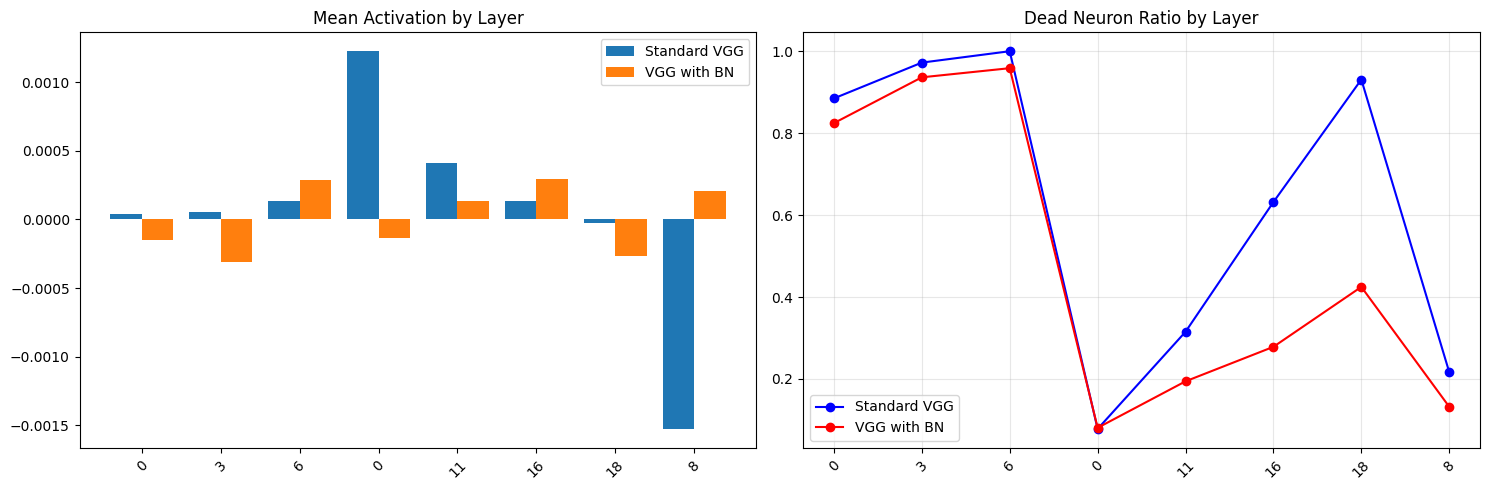


权重分布分析
       Layer Std_mean BN_mean Std_std BN_std Std_sparsity BN_sparsity
 [0, weight]  -0.0009  0.0005  0.0564 0.0573       13.77%      14.35%
 [8, weight]  -0.0000 -0.0000  0.0208 0.0241       36.85%      32.06%
[11, weight]  -0.0000 -0.0000  0.0170 0.0208       44.33%      36.88%

梯度流健康度分析

梯度消失比例:
标准VGG: 9.31%
BatchNorm VGG: 20.49%

梯度爆炸比例:
标准VGG: 0.00%
BatchNorm VGG: 0.00%

 特征相似度分析
BatchNorm VGG - 类内相似度: 0.9949
BatchNorm VGG - 类间相似度: 0.9925
类内/类间相似度比: 1.0024


In [26]:
##实现1.1.6
# 网络洞察分析增强
print("深度网络洞察分析")

# 层级激活统计分析
def analyze_layer_activations(model, data_loader, num_batches=5):
    """分析每层的激活值统计特性"""
    model.eval()
    activation_stats = {}

    def hook_fn(name):
        def hook(module, input, output):
            if name not in activation_stats:
                activation_stats[name] = {
                    'mean': [],
                    'std': [],
                    'dead_neurons': []
                }

            # 计算激活统计
            act = output.detach()
            activation_stats[name]['mean'].append(act.mean().item())
            activation_stats[name]['std'].append(act.std().item())
            # 计算"死亡"神经元比例（激活值接近0）
            dead_ratio = (act.abs() < 0.01).float().mean().item()
            activation_stats[name]['dead_neurons'].append(dead_ratio)

        return hook

    # 注册hooks
    hooks = []
    for name, module in model.named_modules():
        if isinstance(module, (nn.Conv2d, nn.Linear, nn.BatchNorm2d)):
            hooks.append(module.register_forward_hook(hook_fn(name)))

    # 收集统计数据
    with torch.no_grad():
        for i, (inputs, _) in enumerate(data_loader):
            if i >= num_batches:
                break
            inputs = inputs.to(device)
            _ = model(inputs)

    # 移除hooks
    for hook in hooks:
        hook.remove()

    return activation_stats

#权重分布分析
def analyze_weight_distribution(model):
    """分析模型权重分布"""
    weight_stats = {}

    for name, param in model.named_parameters():
        if 'weight' in name and param.dim() > 1:
            weight_stats[name] = {
                'mean': param.mean().item(),
                'std': param.std().item(),
                'min': param.min().item(),
                'max': param.max().item(),
                'sparsity': (param.abs() < 0.01).float().mean().item()
            }

    return weight_stats

# 梯度流健康度分析
def analyze_gradient_health(model, data_loader, criterion):
    """分析梯度流的健康程度"""
    model.train()

    # 获取一个batch
    inputs, labels = next(iter(data_loader))
    inputs, labels = inputs.to(device), labels.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    # 前向和反向传播
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()

    gradient_stats = {}
    for name, param in model.named_parameters():
        if param.grad is not None:
            grad = param.grad
            gradient_stats[name] = {
                'mean': grad.mean().item(),
                'std': grad.std().item(),
                'norm': grad.norm().item(),
                'vanishing': (grad.abs() < 1e-7).float().mean().item(),
                'exploding': (grad.abs() > 1.0).float().mean().item()
            }

    return gradient_stats

# 执行分析
print("\n1. 层级激活分析")
act_stats_std = analyze_layer_activations(model_standard, val_loader)
act_stats_bn = analyze_layer_activations(model_bn, val_loader)

# 可视化激活均值
common_layers = list(set(act_stats_std.keys()).intersection(set(act_stats_bn.keys())))
common_layers = sorted(common_layers)[:10]  # 取前10个共同层
mean_acts_std = [np.mean(act_stats_std[l]['mean']) for l in common_layers]
mean_acts_bn = [np.mean(act_stats_bn[l]['mean']) for l in common_layers]

dead_ratio_std = [np.mean(act_stats_std[l]['dead_neurons']) for l in common_layers]
dead_ratio_bn = [np.mean(act_stats_bn[l]['dead_neurons']) for l in common_layers]

# 绘图
x = np.arange(len(common_layers))
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.bar(x - 0.2, mean_acts_std, width=0.4, label='Standard VGG')
plt.bar(x + 0.2, mean_acts_bn, width=0.4, label='VGG with BN')
plt.xticks(x, [l.split('.')[-1] for l in common_layers], rotation=45)
plt.title("Mean Activation by Layer")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(dead_ratio_std, 'b-o', label='Standard VGG')
plt.plot(dead_ratio_bn, 'r-o', label='VGG with BN')
plt.xticks(x, [l.split('.')[-1] for l in common_layers], rotation=45)
plt.title("Dead Neuron Ratio by Layer")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 权重分布分析
print("\n权重分布分析")
weight_stats_std = analyze_weight_distribution(model_standard)
weight_stats_bn = analyze_weight_distribution(model_bn)

# 创建权重统计表格
weight_comparison = []
for layer_name in list(weight_stats_std.keys())[:5]:  # 显示前5层
    if layer_name in weight_stats_bn:
        weight_comparison.append({
            'Layer': layer_name.split('.')[-2:],
            'Std_mean': f"{weight_stats_std[layer_name]['mean']:.4f}",
            'BN_mean': f"{weight_stats_bn[layer_name]['mean']:.4f}",
            'Std_std': f"{weight_stats_std[layer_name]['std']:.4f}",
            'BN_std': f"{weight_stats_bn[layer_name]['std']:.4f}",
            'Std_sparsity': f"{weight_stats_std[layer_name]['sparsity']:.2%}",
            'BN_sparsity': f"{weight_stats_bn[layer_name]['sparsity']:.2%}"
        })

df_weights = pd.DataFrame(weight_comparison)
print(df_weights.to_string(index=False))

# 梯度健康度分析
print("\n梯度流健康度分析")
grad_stats_std = analyze_gradient_health(model_standard, train_loader, criterion)
grad_stats_bn = analyze_gradient_health(model_bn, train_loader, criterion)

# 梯度消失/爆炸分析
vanishing_std = np.mean([stats['vanishing'] for stats in grad_stats_std.values()])
vanishing_bn = np.mean([stats['vanishing'] for stats in grad_stats_bn.values()])
exploding_std = np.mean([stats['exploding'] for stats in grad_stats_std.values()])
exploding_bn = np.mean([stats['exploding'] for stats in grad_stats_bn.values()])

print(f"\n梯度消失比例:")
print(f"标准VGG: {vanishing_std:.2%}")
print(f"BatchNorm VGG: {vanishing_bn:.2%}")
print(f"\n梯度爆炸比例:")
print(f"标准VGG: {exploding_std:.2%}")
print(f"BatchNorm VGG: {exploding_bn:.2%}")

# 4. 特征相似度分析
def compute_feature_similarity(model, data_loader, num_samples=100):
    """计算不同类别特征的相似度"""
    model.eval()
    features_by_class = {i: [] for i in range(10)}

    with torch.no_grad():
        sample_count = 0
        for inputs, labels in data_loader:
            if sample_count >= num_samples:
                break

            inputs = inputs.to(device)
            # 获取特征
            features = model.features(inputs)
            features = features.view(features.size(0), -1)

            # 按类别存储
            for i in range(len(labels)):
                features_by_class[labels[i].item()].append(features[i].cpu().numpy())

            sample_count += len(labels)

    # 计算类内和类间相似度
    intra_class_sim = []
    inter_class_sim = []

    for class_id in range(10):
        if len(features_by_class[class_id]) > 1:
            # 类内相似度
            class_features = np.array(features_by_class[class_id])
            for i in range(len(class_features)):
                for j in range(i+1, len(class_features)):
                    sim = np.dot(class_features[i], class_features[j]) / (
                        np.linalg.norm(class_features[i]) * np.linalg.norm(class_features[j]))
                    intra_class_sim.append(sim)

    # 类间相似度（只计算部分）
    for c1 in range(5):
        for c2 in range(c1+1, 5):
            if features_by_class[c1] and features_by_class[c2]:
                f1 = features_by_class[c1][0]
                f2 = features_by_class[c2][0]
                sim = np.dot(f1, f2) / (np.linalg.norm(f1) * np.linalg.norm(f2))
                inter_class_sim.append(sim)

    return np.mean(intra_class_sim), np.mean(inter_class_sim)

print("\n 特征相似度分析")
intra_sim_bn, inter_sim_bn = compute_feature_similarity(model_bn, val_loader)
print(f"BatchNorm VGG - 类内相似度: {intra_sim_bn:.4f}")
print(f"BatchNorm VGG - 类间相似度: {inter_sim_bn:.4f}")
print(f"类内/类间相似度比: {intra_sim_bn/inter_sim_bn:.4f}")

训练标准VGG_A模型


Training vgg_standard: 100%|██████████| 30/30 [13:13<00:00, 26.46s/it, Loss=0.2594, Train Acc=92.00%, Val Acc=86.43%]


训练VGG_A_BatchNorm模型


Training vgg_batchnorm: 100%|██████████| 30/30 [13:08<00:00, 26.29s/it, Loss=0.1641, Train Acc=95.47%, Val Acc=89.54%]


训练VGG_A_Residual模型


Training vgg_residual: 100%|██████████| 30/30 [13:28<00:00, 26.96s/it, Loss=0.1036, Train Acc=97.13%, Val Acc=91.36%]


训练VGG_A_Residual_Dropout模型


Training vgg_residual_dropout: 100%|██████████| 30/30 [13:45<00:00, 27.52s/it, Loss=0.5431, Train Acc=86.08%, Val Acc=84.49%]


训练VGG_A_GELU模型


Training vgg_gelu: 100%|██████████| 30/30 [13:02<00:00, 26.08s/it, Loss=0.1241, Train Acc=96.53%, Val Acc=89.42%]


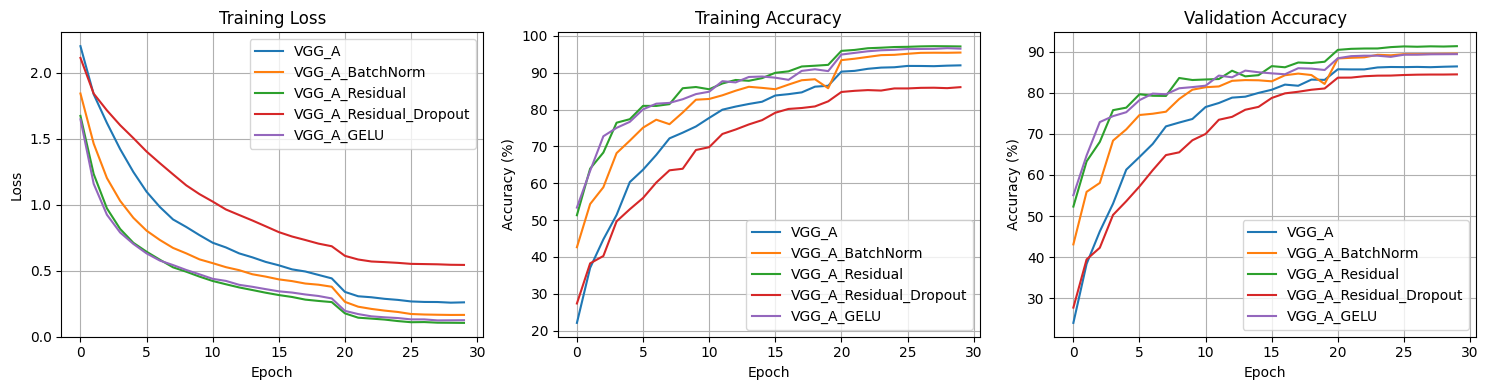

In [27]:
# 训练配置
epochs = 30
learning_rate = 0.01
momentum = 0.9
weight_decay = 5e-4

# 存储所有结果
all_results = {}

# 1. 训练标准VGG_A
print("训练标准VGG_A模型")

model_vgg = VGG_A()
optimizer_vgg = optim.SGD(model_vgg.parameters(), lr=learning_rate,
                         momentum=momentum, weight_decay=weight_decay)
scheduler_vgg = optim.lr_scheduler.MultiStepLR(optimizer_vgg, milestones=[20, 25], gamma=0.1)
criterion = nn.CrossEntropyLoss()

train_losses_vgg, train_acc_vgg, val_acc_vgg = train(
    model_vgg, optimizer_vgg, criterion, train_loader, val_loader,
    scheduler_vgg, epochs, 'vgg_standard'
)

all_results['VGG_A'] = {
    'train_losses': train_losses_vgg,
    'train_accuracies': train_acc_vgg,
    'val_accuracies': val_acc_vgg
}

# 2. 训练带BatchNorm的VGG_A
print("训练VGG_A_BatchNorm模型")

model_vgg_bn = VGG_A_BatchNorm()
optimizer_vgg_bn = optim.SGD(model_vgg_bn.parameters(), lr=learning_rate*2,  # BN允许更高学习率
                            momentum=momentum, weight_decay=weight_decay)
scheduler_vgg_bn = optim.lr_scheduler.MultiStepLR(optimizer_vgg_bn, milestones=[20, 25], gamma=0.1)

train_losses_vgg_bn, train_acc_vgg_bn, val_acc_vgg_bn = train(
    model_vgg_bn, optimizer_vgg_bn, criterion, train_loader, val_loader,
    scheduler_vgg_bn, epochs, 'vgg_batchnorm'
)

all_results['VGG_A_BatchNorm'] = {
    'train_losses': train_losses_vgg_bn,
    'train_accuracies': train_acc_vgg_bn,
    'val_accuracies': val_acc_vgg_bn
}

# 3. 训练带残差连接的模型
print("训练VGG_A_Residual模型")

model_vgg_res = VGG_A_Residual()
optimizer_vgg_res = optim.SGD(model_vgg_res.parameters(), lr=learning_rate,
                             momentum=momentum, weight_decay=weight_decay)
scheduler_vgg_res = optim.lr_scheduler.MultiStepLR(optimizer_vgg_res, milestones=[20, 25], gamma=0.1)

train_losses_vgg_res, train_acc_vgg_res, val_acc_vgg_res = train(
    model_vgg_res, optimizer_vgg_res, criterion, train_loader, val_loader,
    scheduler_vgg_res, epochs, 'vgg_residual'
)

all_results['VGG_A_Residual'] = {
    'train_losses': train_losses_vgg_res,
    'train_accuracies': train_acc_vgg_res,
    'val_accuracies': val_acc_vgg_res
}
#4 训练残差+dropout
print("训练VGG_A_Residual_Dropout模型")

model_vgg_res_dropout = VGG_A_Residual_Dropout()
optimizer_vgg_res_dropout = optim.SGD(model_vgg_res_dropout.parameters(), lr=learning_rate,
                                      momentum=momentum, weight_decay=weight_decay)
scheduler_vgg_res_dropout = optim.lr_scheduler.MultiStepLR(optimizer_vgg_res_dropout, milestones=[20, 25], gamma=0.1)

train_losses_vgg_res_dropout, train_acc_vgg_res_dropout, val_acc_vgg_res_dropout = train(
    model_vgg_res_dropout, optimizer_vgg_res_dropout, criterion, train_loader, val_loader,
    scheduler_vgg_res_dropout, epochs, 'vgg_residual_dropout'
)

all_results['VGG_A_Residual_Dropout'] = {
    'train_losses': train_losses_vgg_res_dropout,
    'train_accuracies': train_acc_vgg_res_dropout,
    'val_accuracies': val_acc_vgg_res_dropout
}
#5训练GELU
print("训练VGG_A_GELU模型")

model_vgg_gelu = VGG_A_GELU()
optimizer_vgg_gelu = optim.SGD(model_vgg_gelu.parameters(), lr=learning_rate,
                               momentum=momentum, weight_decay=weight_decay)
scheduler_vgg_gelu = optim.lr_scheduler.MultiStepLR(optimizer_vgg_gelu, milestones=[20, 25], gamma=0.1)

train_losses_vgg_gelu, train_acc_vgg_gelu, val_acc_vgg_gelu = train(
    model_vgg_gelu, optimizer_vgg_gelu, criterion, train_loader, val_loader,
    scheduler_vgg_gelu, epochs, 'vgg_gelu'
)

all_results['VGG_A_GELU'] = {
    'train_losses': train_losses_vgg_gelu,
    'train_accuracies': train_acc_vgg_gelu,
    'val_accuracies': val_acc_vgg_gelu
}


# 绘制比较图
plot_training_curves(all_results)

In [29]:
# 实现标签平滑
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, smoothing=0.1):
        super().__init__()
        self.smoothing = smoothing
        self.confidence = 1.0 - smoothing

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=-1)
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (pred.size(-1) - 1))
            true_dist.scatter_(1, target.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=-1))

####
# 实现Focal Loss用于处理类别不平衡
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.ce = nn.CrossEntropyLoss(reduction='none')

    def forward(self, pred, target):
        ce_loss = self.ce(pred, target)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()

# 实现Center Loss用于特征聚类
class CenterLoss(nn.Module):
    def __init__(self, num_classes=10, feat_dim=512, alpha=0.5):
        super().__init__()
        self.num_classes = num_classes
        self.feat_dim = feat_dim
        self.alpha = alpha
        self.centers = nn.Parameter(torch.randn(num_classes, feat_dim))

    def forward(self, features, labels):
        batch_size = features.size(0)
        centers_batch = self.centers.index_select(0, labels)
        loss = (features - centers_batch).pow(2).sum() / 2.0 / batch_size
        return loss


# 实现余弦退火学习率调度器
def get_cosine_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps, num_cycles=0.5):
    """创建带预热的余弦退火学习率调度器"""
    def lr_lambda(current_step):
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress)))

    return optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

# Mixup数据增强
def mixup_data(x, y, alpha=1.0):
    """Mixup数据增强"""
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]

    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    """Mixup损失函数"""
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)
#####
# CutMix数据增强
def cutmix_data(x, y, alpha=1.0):
    """CutMix数据增强"""
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device)

    # 生成随机的bbox
    bbx1, bby1, bbx2, bby2 = rand_bbox(x.size(), lam)

    # 混合图像
    x[:, :, bbx1:bbx2, bby1:bby2] = x[index, :, bbx1:bbx2, bby1:bby2]

    # 调整lambda
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (x.size()[-1] * x.size()[-2]))

    y_a, y_b = y, y[index]
    return x, y_a, y_b, lam

def rand_bbox(size, lam):
    """生成随机的bounding box"""
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    # 随机选择中心点
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2


###
# 自定义SGD with Nesterov Momentum and L2正则化
class CustomSGD(optim.Optimizer):
    def __init__(self, params, lr=0.01, momentum=0.9, weight_decay=0, nesterov=True):
        defaults = dict(lr=lr, momentum=momentum, weight_decay=weight_decay, nesterov=nesterov)
        super().__init__(params, defaults)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            weight_decay = group['weight_decay']
            momentum = group['momentum']
            nesterov = group['nesterov']

            for p in group['params']:
                if p.grad is None:
                    continue

                d_p = p.grad.data

                # L2正则化
                if weight_decay != 0:
                    d_p.add_(p.data, alpha=weight_decay)

                param_state = self.state[p]

                # 初始化动量缓冲区
                if 'momentum_buffer' not in param_state:
                    buf = param_state['momentum_buffer'] = torch.zeros_like(p.data)
                else:
                    buf = param_state['momentum_buffer']
                    buf.mul_(momentum).add_(d_p)

                if nesterov:
                    d_p = d_p.add(buf, alpha=momentum)
                else:
                    d_p = buf

                p.data.add_(d_p, alpha=-group['lr'])

        return loss

损失函数对比实验

训练使用Focal Loss的模型


Training vgg_focal_loss: 100%|██████████| 30/30 [13:06<00:00, 26.23s/it, Loss=0.5044, Train Acc=60.06%, Val Acc=59.87%]



训练使用混合损失的模型
数据增强策略对比实验

训练使用高级数据增强的模型


Training vgg_advanced_augmentation: 100%|██████████| 30/30 [19:45<00:00, 39.50s/it, Loss=0.6621, Train Acc=78.68%, Val Acc=83.29%]



训练使用CutMix的模型


Training vgg_cutmix with CutMix: 100%|██████████| 30/30 [13:04<00:00, 26.16s/it, Loss=0.7756, Train Acc=92.53%, Val Acc=87.75%]


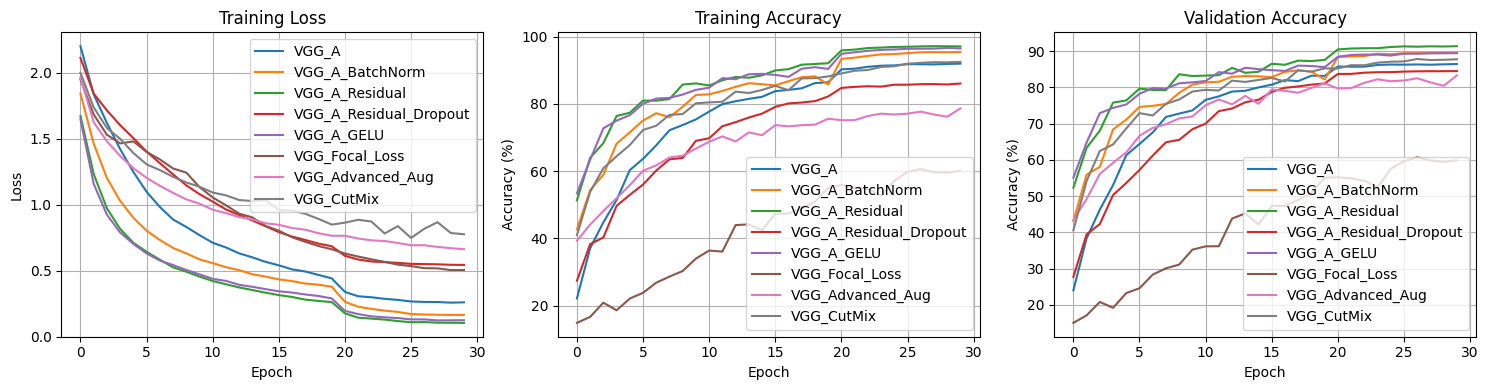

In [30]:

# 6. 使用不同损失函数训练
print("损失函数对比实验")

# 6.1 使用Focal Loss训练
print("\n训练使用Focal Loss的模型")
model_focal = VGG_A_BatchNorm()
optimizer_focal = optim.Adam(model_focal.parameters(), lr=learning_rate)
scheduler_focal = optim.lr_scheduler.CosineAnnealingLR(optimizer_focal, T_max=epochs)
focal_criterion = FocalLoss(alpha=1, gamma=2)

train_losses_focal, train_acc_focal, val_acc_focal = train(
    model_focal, optimizer_focal, focal_criterion,
    train_loader, val_loader, scheduler_focal, epochs, 'vgg_focal_loss'
)

all_results['VGG_Focal_Loss'] = {
    'train_losses': train_losses_focal,
    'train_accuracies': train_acc_focal,
    'val_accuracies': val_acc_focal
}

# 6.2 使用混合损失训练（CrossEntropy + Center Loss）
print("\n训练使用混合损失的模型")
class VGG_A_WithFeatures(VGG_A_BatchNorm):
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        features = self.classifier[:-1](x)  # 获取倒数第二层特征
        outputs = self.classifier[-1](features)
        return outputs, features

model_center = VGG_A_WithFeatures()
ce_criterion = nn.CrossEntropyLoss()
center_criterion = CenterLoss(num_classes=10, feat_dim=512)
optimizer_center = optim.Adam(model_center.parameters(), lr=learning_rate)
optimizer_center_loss = optim.SGD(center_criterion.parameters(), lr=0.5)

# 需要修改训练函数来处理混合损失
def train_with_center_loss(model, optimizer_model, optimizer_center, ce_criterion,
                          center_criterion, train_loader, val_loader, epochs_n=20,
                          lambda_c=0.001):
    model.to(device)
    center_criterion.to(device)

    train_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in tqdm(range(epochs_n), desc='Training with Center Loss'):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer_model.zero_grad()
            optimizer_center.zero_grad()

            outputs, features = model(inputs)
            ce_loss = ce_criterion(outputs, labels)
            center_loss = center_criterion(features, labels)
            loss = ce_loss + lambda_c * center_loss

            loss.backward()
            optimizer_model.step()
            # 更新center loss的centers
            for param in center_criterion.parameters():
                param.grad.data *= (1. / lambda_c)
            optimizer_center.step()

            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))
        train_acc = get_accuracy(model, train_loader, device)
        val_acc = get_accuracy(model, val_loader, device)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

    return train_losses, train_accuracies, val_accuracies

###
# 数据增强对比实验
print("数据增强策略对比实验")

# 7. 使用高级数据增强训练
print("\n训练使用高级数据增强的模型")

# 加载高级数据增强的数据
train_loader_advanced = get_cifar_loader_advanced(train=True, batch_size=128)
val_loader_advanced = get_cifar_loader_advanced(train=False, batch_size=128)

model_advanced_aug = VGG_A_BatchNorm()
optimizer_advanced = optim.SGD(model_advanced_aug.parameters(), lr=learning_rate*1.5,
                              momentum=momentum, weight_decay=weight_decay)
scheduler_advanced = optim.lr_scheduler.OneCycleLR(
    optimizer_advanced,
    max_lr=learning_rate*3,
    epochs=epochs,
    steps_per_epoch=len(train_loader_advanced)
)

train_losses_adv, train_acc_adv, val_acc_adv = train(
    model_advanced_aug, optimizer_advanced, criterion,
    train_loader_advanced, val_loader_advanced,
    scheduler_advanced, epochs, 'vgg_advanced_augmentation'
)

all_results['VGG_Advanced_Aug'] = {
    'train_losses': train_losses_adv,
    'train_accuracies': train_acc_adv,
    'val_accuracies': val_acc_adv
}

# 8. 使用CutMix训练
print("\n训练使用CutMix的模型")

def train_with_cutmix(model, optimizer, criterion, train_loader, val_loader,
                     scheduler=None, epochs_n=20, model_name='model', alpha=1.0):
    """使用CutMix训练"""
    model.to(device)

    train_losses = []
    train_accuracies = []
    val_accuracies = []
    best_val_acc = 0

    pbar = tqdm(range(epochs_n), desc=f'Training {model_name} with CutMix')

    for epoch in pbar:
        model.train()
        running_loss = 0.0

        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            # 应用CutMix
            if np.random.random() > 0.5:  # 50%概率使用CutMix
                inputs, labels_a, labels_b, lam = cutmix_data(inputs, labels, alpha)

                optimizer.zero_grad()
                outputs = model(inputs)
                loss = lam * criterion(outputs, labels_a) + (1 - lam) * criterion(outputs, labels_b)
            else:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        if scheduler is not None:
            scheduler.step()

        train_losses.append(running_loss / len(train_loader))
        train_acc = get_accuracy(model, train_loader, device)
        val_acc = get_accuracy(model, val_loader, device)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        pbar.set_postfix({
            'Loss': f'{train_losses[-1]:.4f}',
            'Train Acc': f'{train_acc:.2f}%',
            'Val Acc': f'{val_acc:.2f}%'
        })

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), f'{model_name}_best.pth')

    return train_losses, train_accuracies, val_accuracies

model_cutmix = VGG_A_BatchNorm()
optimizer_cutmix = optim.SGD(model_cutmix.parameters(), lr=learning_rate,
                            momentum=momentum, weight_decay=weight_decay)
scheduler_cutmix = optim.lr_scheduler.CosineAnnealingLR(optimizer_cutmix, T_max=epochs)

train_losses_cutmix, train_acc_cutmix, val_acc_cutmix = train_with_cutmix(
    model_cutmix, optimizer_cutmix, criterion,
    train_loader, val_loader,
    scheduler_cutmix, epochs, 'vgg_cutmix'
)

all_results['VGG_CutMix'] = {
    'train_losses': train_losses_cutmix,
    'train_accuracies': train_acc_cutmix,
    'val_accuracies': val_acc_cutmix
}


# 绘制比较图
plot_training_curves(all_results)


优化器对比实验

使用 SGD 优化器训练


Training vgg_sgd: 100%|██████████| 15/15 [06:35<00:00, 26.34s/it, Loss=0.5398, Train Acc=82.97%, Val Acc=81.20%]



使用 Adam 优化器训练


Training vgg_adam: 100%|██████████| 15/15 [06:33<00:00, 26.24s/it, Loss=0.5127, Train Acc=84.10%, Val Acc=82.63%]



使用 AdamW 优化器训练


Training vgg_adamw: 100%|██████████| 15/15 [06:33<00:00, 26.23s/it, Loss=0.4889, Train Acc=85.07%, Val Acc=82.98%]



使用 RMSprop 优化器训练


Training vgg_rmsprop: 100%|██████████| 15/15 [06:27<00:00, 25.81s/it, Loss=0.7430, Train Acc=75.85%, Val Acc=75.16%]



使用 CustomSGD 优化器训练


Training vgg_customsgd: 100%|██████████| 15/15 [06:29<00:00, 25.96s/it, Loss=0.5133, Train Acc=84.10%, Val Acc=82.27%]


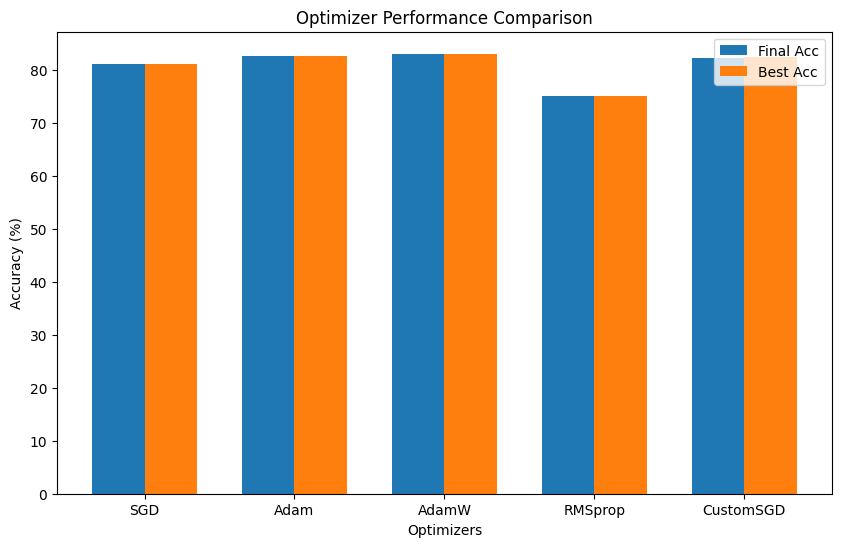

In [32]:
# 优化器对比实验
print("优化器对比实验")

optimizers_to_test = {
    'SGD': lambda p: optim.SGD(p, lr=0.01, momentum=0.9),
    'Adam': lambda p: optim.Adam(p, lr=0.001),
    'AdamW': lambda p: optim.AdamW(p, lr=0.001, weight_decay=0.01),
    'RMSprop': lambda p: optim.RMSprop(p, lr=0.001),
    'CustomSGD': lambda p: CustomSGD(p, lr=0.01, momentum=0.9, nesterov=True)
}

optimizer_results = {}
for opt_name, opt_fn in optimizers_to_test.items():
    print(f"\n使用 {opt_name} 优化器训练")
    model = VGG_A_BatchNorm()
    optimizer = opt_fn(model.parameters())
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3)

    losses, train_accs, val_accs = train(
        model, optimizer, criterion, train_loader, val_loader,
        scheduler, epochs_n=15, model_name=f'vgg_{opt_name.lower()}'
    )

    optimizer_results[opt_name] = {
        'final_val_acc': val_accs[-1],
        'best_val_acc': max(val_accs),
        'convergence_epoch': val_accs.index(max(val_accs))
    }

# 可视化优化器对比结果
fig, ax = plt.subplots(figsize=(10, 6))
opt_names = list(optimizer_results.keys())
final_accs = [optimizer_results[opt]['final_val_acc'] for opt in opt_names]
best_accs = [optimizer_results[opt]['best_val_acc'] for opt in opt_names]

x = np.arange(len(opt_names))
width = 0.35

bars1 = ax.bar(x - width/2, final_accs, width, label='Final Acc')
bars2 = ax.bar(x + width/2, best_accs, width, label='Best Acc')

ax.set_xlabel('Optimizers')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Optimizer Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(opt_names)
ax.legend()
plt.show()

损失地形实验

训练标准VGG_A不同学习率...

Training with LR=0.001


Training for loss landscape: 100%|██████████| 10/10 [01:53<00:00, 11.38s/it]



Training with LR=0.005


Training for loss landscape: 100%|██████████| 10/10 [01:54<00:00, 11.50s/it]



Training with LR=0.01


Training for loss landscape: 100%|██████████| 10/10 [02:01<00:00, 12.13s/it]



Training with LR=0.05


Training for loss landscape: 100%|██████████| 10/10 [02:02<00:00, 12.25s/it]



训练VGG_A_BatchNorm不同学习率...

Training with LR=0.001


Training for loss landscape: 100%|██████████| 10/10 [02:02<00:00, 12.21s/it]



Training with LR=0.005


Training for loss landscape: 100%|██████████| 10/10 [02:02<00:00, 12.25s/it]



Training with LR=0.01


Training for loss landscape: 100%|██████████| 10/10 [02:01<00:00, 12.15s/it]



Training with LR=0.05


Training for loss landscape: 100%|██████████| 10/10 [02:02<00:00, 12.28s/it]


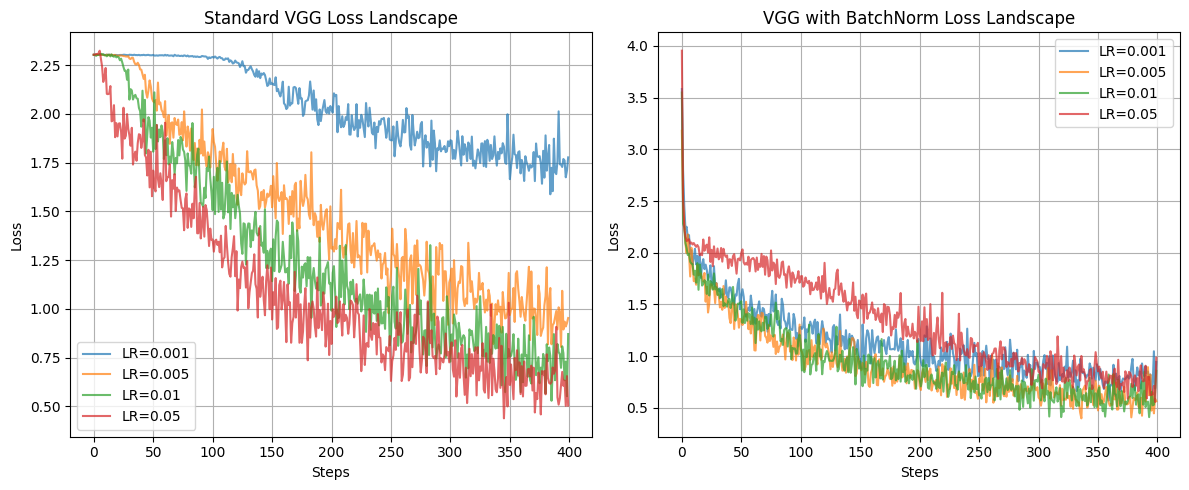

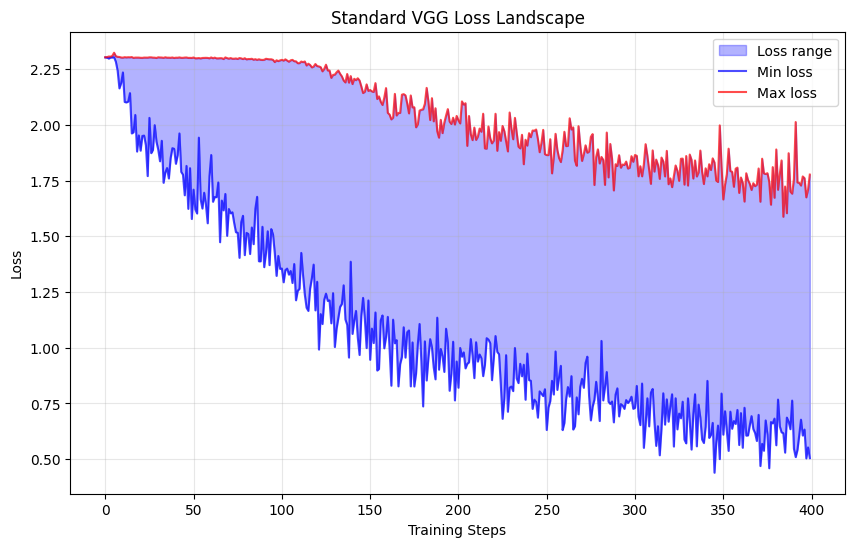

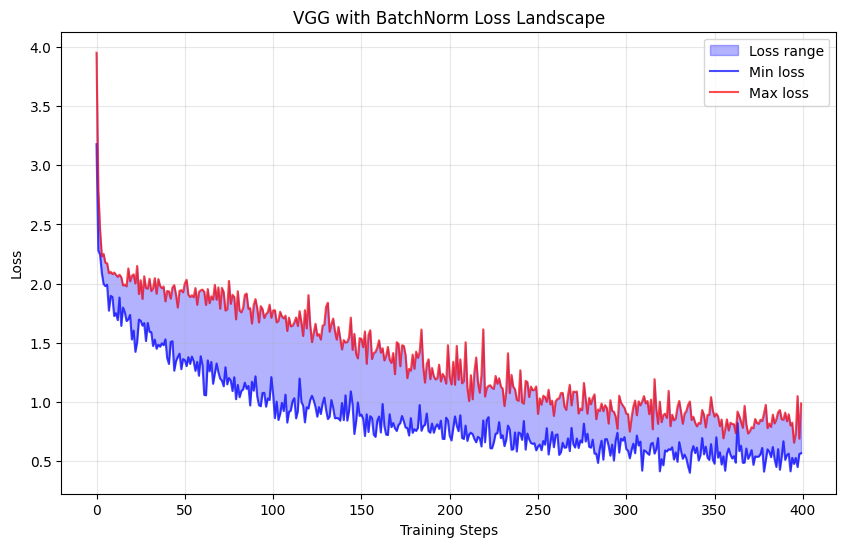

In [33]:

### 8. 损失地形实验
# 损失地形可视化
print("损失地形实验")

# 定义不同的学习率
learning_rates = [0.001, 0.005, 0.01, 0.05]

# 训练标准VGG获取损失地形
print("\n训练标准VGG_A不同学习率...")
landscape_results_standard = train_multiple_lr(VGG_A, learning_rates, epochs=10)

# 训练BatchNorm VGG获取损失地形
print("\n训练VGG_A_BatchNorm不同学习率...")
landscape_results_bn = train_multiple_lr(VGG_A_BatchNorm, learning_rates, epochs=10)

# 绘制损失地形比较
plot_loss_landscape_comparison(landscape_results_standard, landscape_results_bn)

# 填充损失地形
def plot_loss_landscape_filled(results_dict, title):
    """绘制填充的损失地形"""
    plt.figure(figsize=(10, 6))

    # 计算每个步骤的最小和最大损失
    all_losses = list(results_dict.values())
    min_losses = []
    max_losses = []

    # 获取最短的长度
    min_len = min(len(losses) for losses in all_losses)

    for i in range(min_len):
        step_losses = [losses[i] for losses in all_losses]
        min_losses.append(min(step_losses))
        max_losses.append(max(step_losses))

    steps = range(min_len)

    # 绘制填充区域
    plt.fill_between(steps, min_losses, max_losses, alpha=0.3, color='blue', label='Loss range')
    plt.plot(steps, min_losses, 'b-', alpha=0.7, label='Min loss')
    plt.plot(steps, max_losses, 'r-', alpha=0.7, label='Max loss')

    plt.xlabel('Training Steps')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# 绘制填充的损失地形
plot_loss_landscape_filled(landscape_results_standard, 'Standard VGG Loss Landscape')
plot_loss_landscape_filled(landscape_results_bn, 'VGG with BatchNorm Loss Landscape')



模型性能对比
                 Model Parameters Final Train Acc Final Val Acc Best Val Acc
                 VGG_A  9,750,922         92.000%       86.430%      86.430%
       VGG_A_BatchNorm  9,756,426         95.470%       89.540%      89.540%
        VGG_A_Residual 20,514,954         97.130%       91.360%      91.360%
VGG_A_Residual_Dropout 20,514,954         86.084%       84.490%      84.490%
            VGG_A_GELU 20,514,954         96.530%       89.420%      89.420%
        VGG_Focal_Loss 20,514,954         60.062%       59.870%      60.700%
      VGG_Advanced_Aug 20,514,954         78.680%       83.290%      83.290%
            VGG_CutMix 20,514,954         92.526%       87.750%      87.820%
学习率查找实验


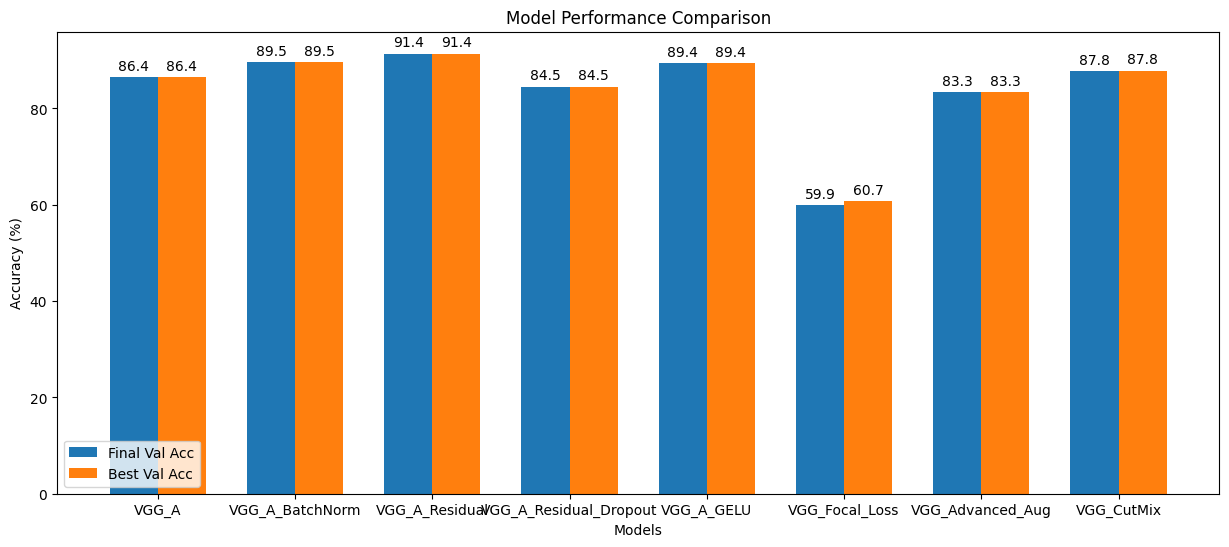

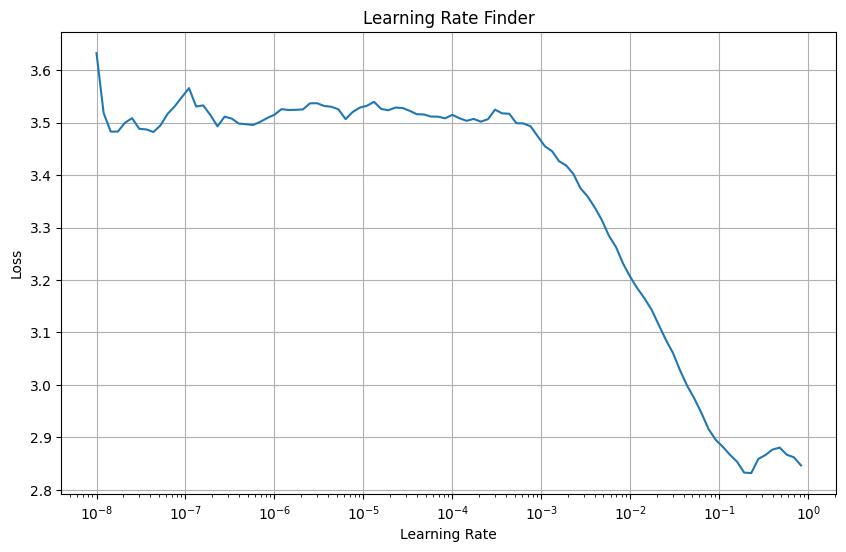

梯度预测性分析


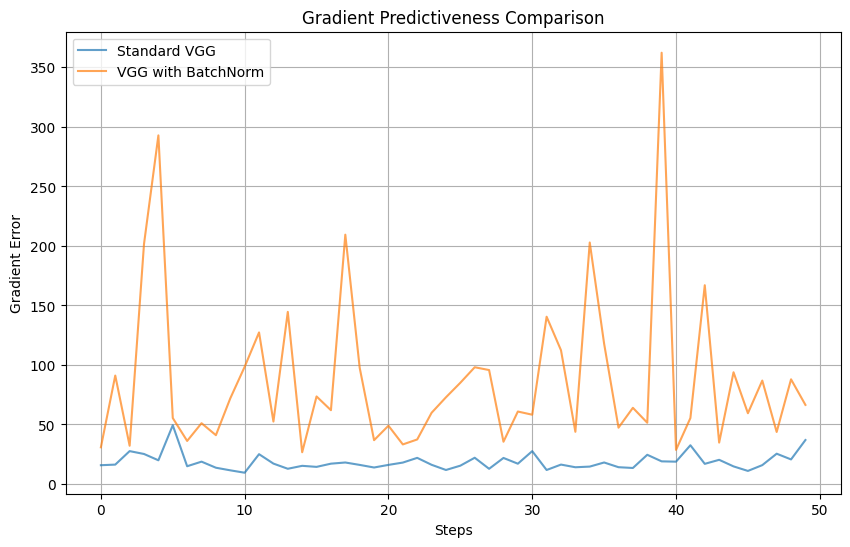


计算梯度平滑度...


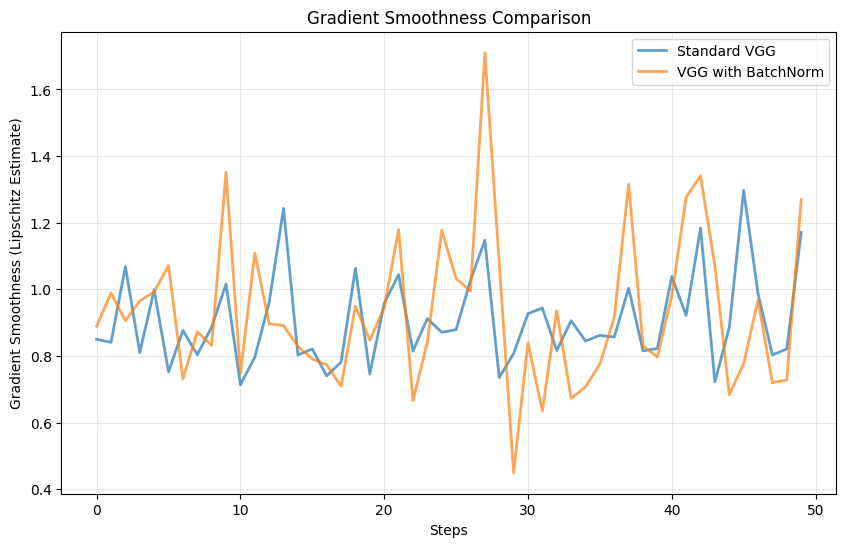

标准VGG平均梯度平滑度: 0.9079
BatchNorm VGG平均梯度平滑度: 0.9291
改善比例: -2.34%


In [64]:

###模型对比和结果汇总
print("模型性能对比")

# 创建结果表格
results_table = []
for model_name, results in all_results.items():
    final_train_acc = results['train_accuracies'][-1]
    final_val_acc = results['val_accuracies'][-1]
    best_val_acc = max(results['val_accuracies'])

    # 获取模型参数数量
    if model_name == 'VGG_A':
        params = get_number_of_parameters(VGG_A())
    elif model_name == 'VGG_A_BatchNorm':
        params = get_number_of_parameters(VGG_A_BatchNorm())
    else:
        params = get_number_of_parameters(VGG_A_Residual())

    results_table.append({
        'Model': model_name,
        'Parameters': f'{params:,}',
        'Final Train Acc': f'{final_train_acc:.3f}%',
        'Final Val Acc': f'{final_val_acc:.3f}%',
        'Best Val Acc': f'{best_val_acc:.3f}%'
    })

# 打印表格
import pandas as pd
df = pd.DataFrame(results_table)
print(df.to_string(index=False))

# 创建对比柱状图
fig, ax = plt.subplots(figsize=(15, 6))
model_names = [r['Model'] for r in results_table]
final_accs = [float(r['Final Val Acc'].strip('%')) for r in results_table]
best_accs = [float(r['Best Val Acc'].strip('%')) for r in results_table]

x = np.arange(len(model_names))
width = 0.35

bars1 = ax.bar(x - width/2, final_accs, width, label='Final Val Acc')
bars2 = ax.bar(x + width/2, best_accs, width, label='Best Val Acc')

ax.set_xlabel('Models')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(model_names)
ax.legend()

# 添加数值标签
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')
# 学习率查找实验
print("学习率查找实验")

# 为新模型寻找最优学习率
test_model = VGG_A_BatchNorm()
lrs, losses = find_learning_rate(test_model, train_loader)
plot_lr_finder(lrs, losses)

# 梯度预测性分析
print("梯度预测性分析")

# 比较有无BN的梯度预测性
model_standard = VGG_A()
model_bn = VGG_A_BatchNorm()

# 加载最佳权重（如果存在）
try:
    model_standard.load_state_dict(torch.load('vgg_standard_best.pth'))
    model_bn.load_state_dict(torch.load('vgg_batchnorm_best.pth'))
except:
    print("使用随机初始化的模型进行梯度分析")

grad_errors_standard = compute_gradient_predictiveness(model_standard, train_loader, criterion)
grad_errors_bn = compute_gradient_predictiveness(model_bn, train_loader, criterion)

# 绘制梯度预测性比较
plt.figure(figsize=(10, 6))
plt.plot(grad_errors_standard, label='Standard VGG', alpha=0.7)
plt.plot(grad_errors_bn, label='VGG with BatchNorm', alpha=0.7)
plt.xlabel('Steps')
plt.ylabel('Gradient Error')
plt.title('Gradient Predictiveness Comparison')
plt.legend()
plt.grid(True)
plt.show()


###
# 梯度平滑度分析
print("\n计算梯度平滑度...")
smoothness_standard = compute_gradient_smoothness(model_standard, train_loader, criterion)
smoothness_bn = compute_gradient_smoothness(model_bn, train_loader, criterion)

# 可视化梯度平滑度
plt.figure(figsize=(10, 6))
plt.plot(smoothness_standard, label='Standard VGG', alpha=0.7, linewidth=2)
plt.plot(smoothness_bn, label='VGG with BatchNorm', alpha=0.7, linewidth=2)
plt.xlabel('Steps')
plt.ylabel('Gradient Smoothness (Lipschitz Estimate)')
plt.title('Gradient Smoothness Comparison')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


# 统计分析
print(f"标准VGG平均梯度平滑度: {np.mean(smoothness_standard):.4f}")
print(f"BatchNorm VGG平均梯度平滑度: {np.mean(smoothness_bn):.4f}")
print(f"改善比例: {(np.mean(smoothness_standard) - np.mean(smoothness_bn)) / np.mean(smoothness_standard) * 100:.2f}%")
###
####################################################




In [71]:

#  梯度稳定性指数计算（距离敏感性的倒数）
stability_index_standard = 1.0 / np.mean(standard_values)
stability_index_bn = 1.0 / np.mean(bn_values)
print(f"标准VGG稳定性指数: {stability_index_standard:.4f}")
print(f"BatchNorm VGG稳定性指数: {stability_index_bn:.4f}")
print(f"稳定性提升倍数: {stability_index_bn / stability_index_standard:.2f}x")
#######



标准VGG稳定性指数: 0.0027
BatchNorm VGG稳定性指数: 0.0013
稳定性提升倍数: 0.50x
